In [1]:
import os
import sys
import pickle
# import rpy2.robjects as robjects
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import scipy.sparse as sp
from torchvision import transforms as tfs
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from torch_geometric.nn import HGTConv, Linear
# from torch_geometric.loader import HGTLoader
from torch.cuda.amp import autocast
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score
#from torchsummary import summary
import random
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from torch.utils.data import WeightedRandomSampler
import math
from Bio import pairwise2
from torch.nn.parameter import Parameter


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed(2022)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

/home/mcb/users/pliu26/anaconda3/envs/pyg25/lib/python3.11/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
def get_acc_p_r_f1(trues, preds):
    labels = [1]
    TP,FP,FN,TN = 0,0,0,0
    for label in labels:
        preds_tmp = np.array([1 if pred == label else 0 for pred in preds])
        trues_tmp = np.array([1 if true == label else 0 for true in trues])
        # print(preds_tmp, trues_tmp)
        # print()
        # TP预测为1真实为1
        # TN预测为0真实为0
        # FN预测为0真实为1
        # FP预测为1真实为0
        TP += ((preds_tmp == 1) & (trues_tmp == 1)).sum()
        TN += ((preds_tmp == 0) & (trues_tmp == 0)).sum()
        FN += ((preds_tmp == 0) & (trues_tmp == 1)).sum()
        FP += ((preds_tmp == 1) & (trues_tmp == 0)).sum()
    print(TP, FP, FN,TN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    accuracy=(TP + TN)/(TP + TN + FP + FN)
    specificity = TN / (TN + FP) 
    npre=TN / (TN + FN)
    fpr=FP/(TN + FP)
    fnr=FN/(TP + FN)
    
    return precision, recall, f1,accuracy,fpr,specificity,npre,fnr

In [3]:
with open('./results/usingmiRNA/HGTfull_resultcpu_usingmiRNAanchor.pkl','rb') as f:  # Python 3: open(..., 'rb')
        tp_hgt,fp_hgt,tn_hgt,fn_hgt,rel_hgt,pre_hgt = pickle.load(f)

In [4]:
with open('./results/usingmiRNA/miRGraphstepbystep_resultgpu_usingmiRNAanchor.pkl','rb') as f:  # Python 3: open(..., 'rb')
        tp_her,fp_her,tn_her,fn_her,rel_her,pre_her = pickle.load(f)

In [5]:
with open('./results/usingmiRNA/miRGraphendtoend_result_usingmiRNAanchor.pkl','rb') as f:  # Python 3: open(..., 'rb')
        tp_her1,fp_her1,tn_her1,fn_her1,rel_her1,pre_her1 = pickle.load(f)

In [6]:
with open('./results/usingmiRNA/TransCNN_resultgpu_usingmiRNAanchor.pkl','rb') as f:  # Python 3: open(..., 'rb')
        tp_cnn,fp_cnn,tn_cnn,fn_cnn,rel_cnn,pre_cnn = pickle.load(f)

In [7]:
with open('./results/usingmiRNA/RGCN_BiLSTM_resultgpu_usingmiRNAanchor.pkl','rb') as f:  # Python 3: open(..., 'rb')
        tp_rb,fp_rb,tn_rb,fn_rb,rel_rb,pre_rb = pickle.load(f)

In [8]:
with open('./results/usingmiRNA/RCGN_resultgpu_usingmiRNAanchor.pkl','rb') as f:  # Python 3: open(..., 'rb')
        tp_r,fp_r,tn_r,fn_r,rel_r,pre_r = pickle.load(f)

In [9]:
with open('./results/usingmiRNA/HGT_BiLSTM_resultcpu.pkl','rb') as f:  # Python 3: open(..., 'rb')
        tp_hb,fp_hb,tn_hb,fn_hb,rel_hb,pre_hb = pickle.load(f)

In [10]:
fpr1, tpr1, thresholds = roc_curve(rel_hgt,pre_hgt, pos_label=1)
auc_value1=auc(fpr1,tpr1)
precision1, recall1, _ = precision_recall_curve(rel_hgt,pre_hgt,pos_label=1)
aupr1 = average_precision_score(rel_hgt,pre_hgt,pos_label=1)
print(auc_value1,aupr1)

0.7953477644067963 0.6573901576197811


In [11]:
fpr2, tpr2, thresholds = roc_curve(rel_her,pre_her, pos_label=1)
auc_value2=auc(fpr2,tpr2)
precision2, recall2, _ = precision_recall_curve(rel_her,pre_her,pos_label=1)
aupr2 = average_precision_score(rel_her,pre_her,pos_label=1)
print(auc_value2,aupr2)

0.8861764057193446 0.8072016865258621


In [12]:
fpr3, tpr3, thresholds = roc_curve(rel_cnn,pre_cnn, pos_label=1)
auc_value3=auc(fpr3,tpr3)
precision3, recall3, _ = precision_recall_curve(rel_cnn,pre_cnn,pos_label=1)
aupr3 = average_precision_score(rel_cnn,pre_cnn,pos_label=1)
print(auc_value3,aupr3)

0.8885637606662133 0.8057250851652422


In [13]:
fpr4, tpr4, thresholds = roc_curve(rel_rb,pre_rb, pos_label=1)
auc_value4=auc(fpr4,tpr4)
precision4, recall4, _ = precision_recall_curve(rel_rb,pre_rb,pos_label=1)
aupr4 = average_precision_score(rel_rb,pre_rb,pos_label=1)
print(auc_value4,aupr4)

0.7474589400522162 0.5972246127282413


In [14]:
fpr5, tpr5, thresholds = roc_curve(rel_r,pre_r, pos_label=1)
auc_value5=auc(fpr5,tpr5)
precision5, recall5, _ = precision_recall_curve(rel_r,pre_r,pos_label=1)
aupr5 = average_precision_score(rel_r,pre_r,pos_label=1)
print(auc_value5,aupr5)

0.6782495875956539 0.5248681553613435


In [15]:
fpr6, tpr6, thresholds = roc_curve(rel_hb,pre_hb, pos_label=1)
auc_value6=auc(fpr6,tpr6)
precision6, recall6, _ = precision_recall_curve(rel_hb,pre_hb,pos_label=1)
aupr6 = average_precision_score(rel_hb,pre_hb,pos_label=1)
print(auc_value6,aupr6)

0.7809970102033221 0.6355522190654771


In [16]:
fpr7, tpr7, thresholds = roc_curve(rel_her1,pre_her1, pos_label=1)
auc_value7=auc(fpr7,tpr7)
precision7, recall7, _ = precision_recall_curve(rel_her1,pre_her1,pos_label=1)
aupr7 = average_precision_score(rel_her1,pre_her1,pos_label=1)
print(auc_value7,aupr7)

0.8784993787043432 0.7867700301361816


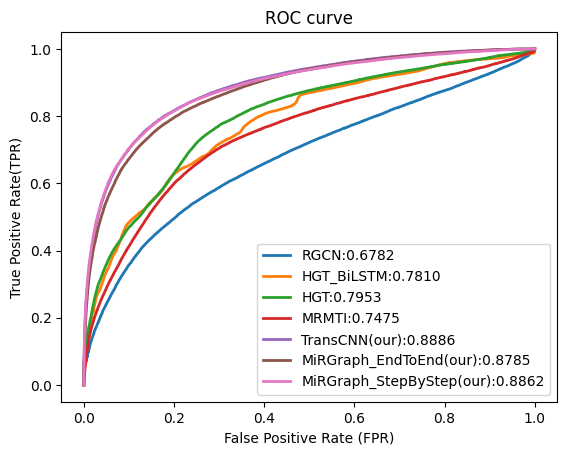

In [19]:
plt.figure()
plt.step(fpr5, tpr5,linewidth=2,label='RGCN:{0:.4f}'.format(auc_value5))
plt.step(fpr6, tpr6,linewidth=2,label='HGT_BiLSTM:{0:.4f}'.format(auc_value6))
plt.step(fpr1, tpr1,linewidth=2,label='HGT:{0:.4f}'.format(auc_value1))
plt.step(fpr4, tpr4,linewidth=2,label='MRMTI:{0:.4f}'.format(auc_value4))
plt.step(fpr3, tpr3,linewidth=2,label='TransCNN(our):{0:.4f}'.format(auc_value3))
plt.step(fpr7, tpr7,linewidth=2,label='MiRGraph_EndToEnd(our):{0:.4f}'.format(auc_value7))
plt.step(fpr2, tpr2,linewidth=2,label='MiRGraph_StepByStep(our):{0:.4f}'.format(auc_value2))
#plt.step(fpr7, tpr7,linewidth=2,label='MiRGraph_EndToEnd(our):{0:.4f}'.format(auc_value7))
#plt.plot([0, 0], [1, 1], color='navy',linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate(TPR)' )
plt.title('ROC curve')
plt.legend(loc=4)
#plt.savefig('./ROC_6_1.jpg')
plt.savefig('./results/usingmiRNA/ROC_7.pdf', bbox_inches='tight')

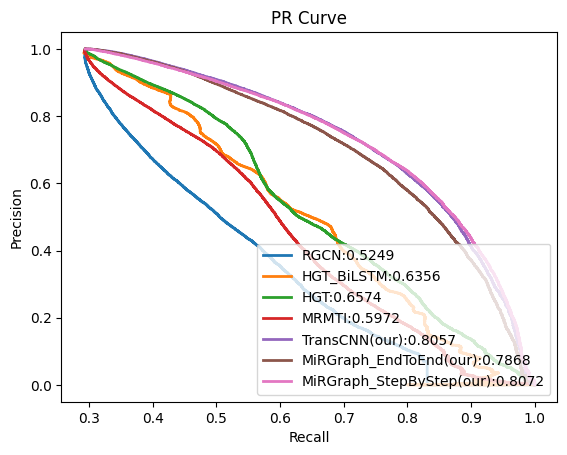

In [20]:
plt.figure()
plt.step(precision5, recall5,linewidth=2,label='RGCN:{0:.4f}'.format(aupr5))
#plt.step(precision6, recall6,linewidth=2,label='HGT_BiLSTM:{0:.4f})'.format(aupr6))
plt.step(precision6, recall6,linewidth=2,label='HGT_BiLSTM:{0:.4f}'.format(aupr6))
plt.step(precision1, recall1,linewidth=2,label='HGT:{0:.4f}'.format(aupr1))
plt.step(precision4, recall4,linewidth=2,label='MRMTI:{0:.4f}'.format(aupr4))
plt.step(precision3, recall3,linewidth=2,label='TransCNN(our):{0:.4f}'.format(aupr3))
#plt.step(precision2, recall2,linewidth=2,label='MiRGraph_StepByStep(our):{0:.4f}'.format(aupr2))
plt.step(precision7, recall7,linewidth=2,label='MiRGraph_EndToEnd(our):{0:.4f}'.format(aupr7))
plt.step(precision2, recall2,linewidth=2,label='MiRGraph_StepByStep(our):{0:.4f}'.format(aupr2))
#plt.plot([0, 0], [1, 1], color='navy',linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
plt.legend(loc=4)
plt.savefig('./results/usingmiRNA/PR_7.pdf', bbox_inches='tight')

In [21]:
s1 = pre_hgt
s1[s1 > 0.5] = 1
s1[s1 <= 0.5] = 0
precision, recall, f1,accuracy,fpr,specificity,npre,fnr=get_acc_p_r_f1(rel_hgt,pre_hgt)
print(precision, recall, f1,accuracy,fpr,specificity,npre,fnr)

29262 40183 4098 39853
0.42136942904456764 0.8771582733812949 0.5692719225718593 0.6095012169741437 0.5020615722924684 0.4979384277075316 0.9067598006871288 0.12284172661870503


In [22]:
s1 = pre_her
s1[s1 > 0.5] = 1
s1[s1 <= 0.5] = 0
precision, recall, f1,accuracy,fpr,specificity,npre,fnr=get_acc_p_r_f1(rel_her,pre_her)
print(precision, recall, f1,accuracy,fpr,specificity,npre,fnr)

23570 8181 9790 71855
0.742338823974048 0.7065347721822542 0.723994409546774 0.8415199830681859 0.10221650257384177 0.8977834974261583 0.8800906362912609 0.2934652278177458


In [23]:
s1 = pre_her1
s1[s1 > 0.5] = 1
s1[s1 <= 0.5] = 0
precision, recall, f1,accuracy,fpr,specificity,npre,fnr=get_acc_p_r_f1(rel_her1,pre_her1)
print(precision, recall, f1,accuracy,fpr,specificity,npre,fnr)

26243 15206 7117 64830
0.6331395208569568 0.7866606714628297 0.7016000748573032 0.8031412042752831 0.1899895047228747 0.8100104952771253 0.9010799616384283 0.21333932853717028


In [24]:
s1 = pre_cnn
s1[s1 > 0.5] = 1
s1[s1 <= 0.5] = 0
precision, recall, f1,accuracy,fpr,specificity,npre,fnr=get_acc_p_r_f1(rel_cnn,pre_cnn)
print(precision, recall, f1,accuracy,fpr,specificity,npre,fnr)

26663 14193 6697 65843
0.6526091638926963 0.7992505995203837 0.7185243074269699 0.8157783343327807 0.1773327002848718 0.8226672997151282 0.9076785221946512 0.2007494004796163


In [25]:
s1 = pre_rb
s1[s1 > 0.5] = 1
s1[s1 <= 0.5] = 0
precision, recall, f1,accuracy,fpr,specificity,npre,fnr=get_acc_p_r_f1(rel_rb,pre_rb)
print(precision, recall, f1,accuracy,fpr,specificity,npre,fnr)

22050 20277 11310 59759
0.5209440782479269 0.6609712230215827 0.5826628086725594 0.7214452008889203 0.25334849317806984 0.7466515068219302 0.8408588836201438 0.33902877697841727


In [26]:
s1 = pre_r
s1[s1 > 0.5] = 1
s1[s1 <= 0.5] = 0
precision, recall, f1,accuracy,fpr,specificity,npre,fnr=get_acc_p_r_f1(rel_r,pre_r)
print(precision, recall, f1,accuracy,fpr,specificity,npre,fnr)

16591 16155 16769 63881
0.506657301655164 0.49733213429256595 0.5019514113696185 0.7096546615400896 0.20184666899895048 0.7981533310010496 0.7920768753874767 0.502667865707434


#### s1 = pre_hb
s1[s1 > 0.5] = 1
s1[s1 <= 0.5] = 0
precision, recall, f1,accuracy,fpr,specificity,npre,fnr=get_acc_p_r_f1(rel_hb,pre_hb)
print(precision, recall, f1,accuracy,fpr,specificity,npre,fnr)

In [ ]:
#### Case Study

In [1]:
# import os
# import sys
# import pickle
# # import rpy2.robjects as robjects
# import torch
# from torch.autograd import Variable
# import torch.nn.functional as F
# from torch import nn
# from torch.utils.data import Dataset, DataLoader, random_split
# import numpy as np
# import scipy.sparse as sp
# from torchvision import transforms as tfs
# from torch_geometric.data import HeteroData
# import torch_geometric.transforms as T
# from torch_geometric.nn import HGTConv, Linear
# # from torch_geometric.loader import HGTLoader
# from torch.cuda.amp import autocast
# from torch_geometric.utils import negative_sampling
# from sklearn.metrics import roc_auc_score
# from torchsummary import summary
# import random
# from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
# from torch.utils.data import WeightedRandomSampler
# import math
# from einops import rearrange, reduce
# from einops.layers.torch import Rearrange
# from Bio import pairwise2
# from torch.nn.parameter import Parameter


# def set_seed(seed):
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)


# set_seed(2022)
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# with open('/lustre06/project/6050659/liupei89/Testcell/predictUnknownData_Score.pkl','rb') as f:  # Python 3: open(..., 'rb')
#         allunknown,pre,xm,xg = pickle.load(f)